In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.rollout import ROLLOUT
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 1. load data

In [2]:
dataset_name = 'news'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [item['article'] for item in train_dataset]
    train_highlights = [item['highlights'] for item in train_dataset]
    val_articles = [item['article'] for item in val_dataset]
    val_highlights = [item['highlights'] for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 745 ms, sys: 23.9 ms, total: 769 ms
Wall time: 768 ms


### 2. sentencepiece model

In [4]:
train_new_model = False

In [5]:
%%time
if train_new_model:
    with open('data/news_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                                   model_prefix='news10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


### 3. dataset and dataloaders

In [6]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/news{int(vocab_size/1000)}k.model'

In [7]:
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [8]:
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [9]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([102, 128])
torch.Size([24, 128])


### 4. model architecture

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [11]:
writer = SummaryWriter()

In [12]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)

### 5. generator pretraining

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 1e-3
opt = torch.optim.Adam(G.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5)
start_teacher_forcing = 0.5
teacher_forcing_decay = 0.025
n_epochs = 50

epoch_losses = []
val_losses = []
iter_num = -1

In [16]:
for epoch_idx in range(n_epochs):
    G.train()
    total_loss = 0.
    teacher_forcing = start_teacher_forcing - epoch_idx*teacher_forcing_decay
    for batch_idx, data_input in tqdm(enumerate(train_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        opt.zero_grad()
        out = G(article, highlight, teacher_forcing_ratio=teacher_forcing)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1)
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset))
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    val_loss = total_loss / len(val_dataset)
    val_losses.append(val_loss)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    
    scheduler.step(val_loss)
    print(f'current lr {get_lr(opt)}')
    print(f'current teacher forcing: {teacher_forcing}')
    
    indices = sps.randint(0, out.size(1)).rvs(size=5)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        print(f'predicted: {pred}')
        print(f'truth: {truth}\n')

20it [00:03,  6.21it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('generator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# save_path = 'saved_models/pretrained_seq2seq_gen_3.pth'
# torch.save(G.state_dict(), save_path)

### 6. discriminator pretraining

In [17]:
save_path = 'saved_models/pretrained_seq2seq_gen.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [18]:
G.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [19]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)

In [20]:
criterion = nn.BCELoss()
lr = 1e-4
opt = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 2

epoch_losses = []
val_losses = []
iter_num = -1
writer = SummaryWriter()

In [21]:
for epoch_idx in range(n_epochs):
    D.train()
    total_loss = 0.
    
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        opt.zero_grad()
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    D.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        total_loss += loss.data.item() * article.size(1) * 2

    val_losses.append(total_loss / len(val_dataset) / 2)
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [00:43, 12.46it/s]
2it [00:00, 14.30it/s]

epoch 0 train loss: 0.3928120992947954


231it [00:15, 14.44it/s]
2it [00:00, 12.97it/s]

epoch 0 val loss: 0.10172562454329778


539it [00:43, 12.45it/s]
2it [00:00, 13.75it/s]

epoch 1 train loss: 0.1146431076298192


231it [00:15, 14.45it/s]

epoch 1 val loss: 0.021911663011058163


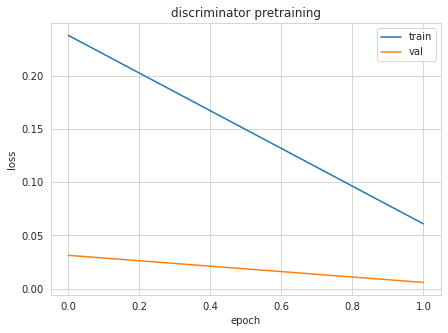

In [22]:
plt.figure(figsize=(7, 5))
plt.title('discriminator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
save_path = 'saved_models/pretrained_dis3.pth'
torch.save(D.state_dict(), save_path)

### 7. adversarial training

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
vocab_size = 10000
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/pretrained_seq2seq_gen_3.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/pretrained_dis3.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [14]:
n_epochs = 60
rollout_num = 2
beta = 0.2
teacher_forcing = 0.6

In [15]:
writer = SummaryWriter()

In [16]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [17]:
D.train()

CNNDiscriminator(
  (embed): Embedding(10000, 256, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 256), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 256), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(3, 256), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
)

In [ ]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion_ml = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, 'min', patience=5)

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    beta += 0.02 * epoch_idx
    beta = min(0.95, beta)
    teacher_forcing -= 0.02 * epoch_idx
    teacher_forcing = max(0, teacher_forcing)
    writer.add_scalar('Params/teacher_forcing', teacher_forcing, iter_num)
    writer.add_scalar('Params/beta', beta, iter_num)
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        '''
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = generated_highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        '''
        iter_num += 1
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=teacher_forcing)
        generated_highlight = generated_highlight.permute(1, 0)  # (batch_size, seq_len)
        rollout_func = ROLLOUT(G)
        rewards = rollout_func.get_reward(article, highlight.permute(1, 0), rollout_num, D)
        writer.add_scalar('Reward/train', rewards.mean().data.item(), iter_num)
        # rewards = 1 - rewards
        pg_loss = G.batch_pgloss_generated(gen_out, highlight.permute(1, 0), rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=teacher_forcing)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss_train/loss', loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/ml_loss', ml_loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/pg_loss', pg_loss.data.item(), iter_num)
        total_G_loss += loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    total_reward = 0.
    total_ml_loss = 0.
    total_pg_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = generated_highlight.permute(1, 0)  # (batch_size, seq_len)
        rollout_func = ROLLOUT(G)
        rewards = rollout_func.get_reward(article, highlight.permute(1, 0), rollout_num, D)
        total_reward += rewards.mean().data.item() * article.size(1)
        # rewards = 1 - rewards
        pg_loss = G.batch_pgloss_generated(gen_out, highlight.permute(1, 0), rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=0.)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        total_loss += loss.data.item() * article.size(1)
        
        total_ml_loss += ml_loss.data.item() * article.size(1)
        total_pg_loss += pg_loss.data.item() * article.size(1)
    writer.add_scalar('Reward/val', total_reward / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/loss', total_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/ml_loss', total_ml_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/pg_loss', total_pg_loss / len(val_dataset), iter_num)
    
    scheduler.step(total_loss)
    
    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    # writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    
    
    indices = sps.randint(0, out.size(1)).rvs(size=10)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        writer.add_text('Texts/pred', pred, iter_num)
        writer.add_text('Texts/truth', truth, iter_num)
        print(f'predicted: {pred}')
        print(f'truth: {truth}\n')

539it [15:20,  1.71s/it]
0it [00:00, ?it/s]

epoch 0 G loss: 3.0428482192457067
epoch 0 D loss: 0.0


231it [04:49,  1.25s/it]


epoch 0 val loss: 5.598559960969753


0it [00:00, ?it/s]

predicted: airbus probe probe probe corruption charges insexexexex
truth: airbus launches internal corruption investigation

predicted: french singer ss dies after collapsing in in
truth: french singer barbara weldens dies on stage during concert

predicted: airbus probe probe probe corruption charges insexexexex
truth: airbus launches internal corruption investigation

predicted: pm pm pm pm pm sssnanana s resigns
truth: georgia pm kvirikashvili resigns amid rift with ruling party

predicted: daughters should t t  good good touch touch mp cm
truth: daughters should be taught about good bad touch mp cm

predicted: kejriwal kejriwal kejriwal defamation defamation case against delhi
truth: delhi cm discharged in defamation case over thulla remark

predicted: us man awarded 4 4 crore after eating burntopopusus
truth: us man awarded 4 8 crore after beer burns his organs

predicted: barcelona 1st club club to earn over 44 bn in
truth: barcelona become world s 1st team to spend 500 million o

539it [15:35,  1.74s/it]
0it [00:00, ?it/s]

epoch 1 G loss: 2.8284000407804872
epoch 1 D loss: 0.0


231it [04:50,  1.26s/it]


epoch 1 val loss: 5.575447749519755


0it [00:00, ?it/s]

predicted: airbus probe probe into corruption charges insexexexex
truth: airbus launches internal corruption investigation

predicted: my child sawenenclaimsss s abd to kid
truth: de villiers hid love letters he wrote in his house s roof

predicted: b luru police challenges challenge onoutoutoutout pic
truth: b luru police ask people to wear helmets share 10 secs challenge

predicted: nasa propose proposes using co comicmicmics glass
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: nasa probess of 1 lakh lakh indians on a chip
truth: nasa spacecraft landed on mars with names of over 1l indians

predicted: nation will become asian pure under imran imran khan
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: 35 men married married atpointpoint in bihar 2016
truth: 3 075 grooms got married in bihar at gunpoint in 2016

predicted: amazon should pay real money real money taxes donald trump
truth: amazon must pay real costs and taxes now 

539it [15:35,  1.73s/it]
0it [00:00, ?it/s]

epoch 2 G loss: 2.7974252279904106
epoch 2 D loss: 0.0


231it [04:50,  1.26s/it]


epoch 2 val loss: 5.452959704296541


0it [00:00, ?it/s]

predicted: gotaradhya for the from my my actor on on 13 years
truth: received best compliment from dilip kumar for black big b

predicted: ddkock rules out of ipl ipl match to to match
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: pak ak ak player as ased from trophy trophyninini
truth: akmal should be ashamed for being sent back to pak waqar

predicted: french singer ss dies after collapsing in concert
truth: french singer barbara weldens dies on stage during concert

predicted: astronomers helped wavesed earth 96 years ago study
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: astronomers helped wavesed earth 96 years ago study
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: 4 missiles fired from afghanistan in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted: srikanthambi srikanth conferred padma shri
truth: kidambi srikanth conferred with padma shri award

pred

539it [15:36,  1.74s/it]
0it [00:00, ?it/s]

epoch 3 G loss: 2.7772496618321827
epoch 3 D loss: 0.0


231it [04:49,  1.25s/it]


epoch 3 val loss: 5.287601828853765


0it [00:00, ?it/s]

predicted: i suffering for a mistake conductor conductor conductor driver driver driver driver
truth: suffering for no fault driver who let langur control steering

predicted: ferrari s f driver driver crashes car car car pr1 car
truth: f1 driver crashes after race ends rides back on another car

predicted: amazon to test 1 hr for items in fashion show show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: world s smallest computers made neuros
truth: how does the world s smallest computer work

predicted: 2015 shooters married married atpoint in bihar 2016
truth: 3 075 grooms got married in bihar at gunpoint in 2016

predicted: cbi of witch hunting in evidence of sarushia
truth: cbi planted witnesses in aarushi murder case allahabad hc

predicted: us man awarded 4 8 8 after eating corpses
truth: us man awarded 4 8 crore after beer burns his organs

predicted: sachin attend attend b day s b m ambani vikram ambani
truth: sachin tendulkar attends krunal pa

539it [15:35,  1.74s/it]
0it [00:00, ?it/s]

epoch 4 G loss: 2.7639627619487483
epoch 4 D loss: 0.0


231it [04:50,  1.26s/it]


epoch 4 val loss: 5.076564761601443


0it [00:00, ?it/s]

predicted: nation will become asian pure under imran imran khan
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: cannot be run by byss sports sports sports min
truth: sports can t be run by bureaucrats sports minister rathore

predicted: vajpayee was firstst to a speech in the from the nation
truth: late pm vajpayee was 1st person to give hindi speech at un

predicted: kerala govting sabarimalasssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: aus australia is is good good good good aus coachlanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: mumbai was 1st first teacher teacher teacher in child child
truth: who was savitribai phule india s first female teacher

predicted: death toll in gorkhaland strike killed in gorkhaland
truth: gorkhaland supporter killed in police firing in darjeeling

predicted: rhea s sister  sister s 1st at cannes festival fest
truth: sonam wears custom made

539it [15:24,  1.72s/it]
0it [00:00, ?it/s]

epoch 5 G loss: 2.755716007844081
epoch 5 D loss: 0.0


231it [04:40,  1.21s/it]


epoch 5 val loss: 4.844102089831727


0it [00:00, ?it/s]

predicted: sehwag moreinging sehwag oninginging pad pad
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: death toll in gorkhaland strike killed in gorkhaland
truth: gorkhaland supporter killed in police firing in darjeeling

predicted: he have death under undereacheacheacheachss owaisi owaisi
truth: threat to my life claims aimim leader akbaruddin owaisi

predicted: mccullum scores test test fastest fastest in his last last last
truth: brendon mccullum hit test cricket s fastest ton in his last match

predicted: un evidence of evidence of human rights rights attack
truth: enough evidence to convict syrian prez of war crimes un

predicted: demonetismohan waseded butededed minister minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: amazon to test 1 hr for for items show show show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: kerala govting sabarimalasssssssss shah
truth: kerala treatin

539it [15:13,  1.70s/it]
0it [00:00, ?it/s]

epoch 6 G loss: 2.738384617385687
epoch 6 D loss: 0.0


231it [04:40,  1.22s/it]


epoch 6 val loss: 4.578166625052383


0it [00:00, ?it/s]

predicted: keralas make plastic freess for for for marriage
truth: village issues marriage certificate only after green wedding

predicted: man dies after rid dies dies dies in tripping into car
truth: man dies after crashing his scooter into zareen khan s car in goa

predicted: nasa probe probes of lakh lakh 38 lakhs on on a
truth: nasa spacecraft landed on mars with names of over 1l indians

predicted: barable to be against soldiers armyss army army army
truth: soldiers to face action for disrespecting militants bodies

predicted: first look poster of sushant kriti starrer raabta unveiled
truth: first look poster of sushant kriti s raabta unveiled

predicted: india smell noting blood buty would be under great coach coach
truth: india are smelling blood we will show them great respect langer

predicted: kejriwal kejriwal kejriwal defamation defamation casestst police
truth: delhi cm discharged in defamation case over thulla remark

predicted: sehwag moreinginging sehwag on pad pad pad

539it [15:15,  1.70s/it]
0it [00:00, ?it/s]

epoch 7 G loss: 2.680413704383664
epoch 7 D loss: 0.0


231it [04:40,  1.21s/it]


epoch 7 val loss: 4.300981256867411


0it [00:00, ?it/s]

predicted: social media mediasenenenss trump trump trump
truth: social media giants are silencing millions of people trump

predicted: vajpayee was firstst to speech speech in in  
truth: late pm vajpayee was 1st person to give hindi speech at un

predicted: nasa propose proposess co comicmicmicmicing glass
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: barable to be against soldiers armyss army army army
truth: soldiers to face action for disrespecting militants bodies

predicted: wheelchair passengerseded to flight flight flight flight flight flight
truth: air india refuses to let wheelchair bound passenger on plane

predicted: man buildssable  in in car water the the
truth: man turns his car into a drivable hot tub

predicted: barcelona 1s 1st in world to ins
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: 23 billionaire billionairesst hurunsss
truth: 27 hurun rich list billionaires passed away last year

predicted: iit 

539it [15:15,  1.70s/it]
0it [00:00, ?it/s]

epoch 8 G loss: 2.5365488761254995
epoch 8 D loss: 0.0


231it [04:39,  1.21s/it]


epoch 8 val loss: 4.0406626625955235


0it [00:00, ?it/s]

predicted: zo winds put women at at foree g gnt
truth: game of thrones puts women at the forefront gwendoline

predicted: demonetismohan wasedededededed minister minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: sehwag moreinginging sehwag pad pad pad pad ss
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: union union minister minister minister swor swor in in bihar of
truth: satya pal malik sworn in as governor of bihar

predicted: amazon to test 1 hr for for itemsnn show show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: ferrari s driver driver car car car car car car pr pr car car
truth: f1 driver crashes after race ends rides back on another car

predicted: nation will become pure pure under imran imran khan akhtar
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: nation will become pure pure under imran imran khan akhtar
truth: pak will become asian 

539it [15:10,  1.69s/it]
0it [00:00, ?it/s]

epoch 9 G loss: 2.503578015846935
epoch 9 D loss: 0.0


231it [04:38,  1.20s/it]


epoch 9 val loss: 3.9974233313412175


0it [00:00, ?it/s]

predicted: pm pm pm pm pm pmsnanananana
truth: georgia pm kvirikashvili resigns amid rift with ruling party

predicted: never think about what i have have ve ining in kajol kajol
truth: i never think about what i should ve done differently kajol

predicted: australian australia is is good good good good goodlangerlangerlanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: pm pm pm pm pm pmsnanananana
truth: georgia pm kvirikashvili resigns amid rift with ruling party

predicted: nurse whos for foringingingmemese to baby
truth: italian nurse jailed for calming newborn with morphine

predicted: barable to be against soldiers army armys army army army
truth: soldiers to face action for disrespecting militants bodies

predicted: d dekockkock rule out out ipl ipl ipl 10 to touch
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: 4 missiles firededfrom in in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted:

539it [15:09,  1.69s/it]
0it [00:00, ?it/s]

epoch 10 G loss: 2.495829873301011
epoch 10 D loss: 0.0


231it [04:40,  1.22s/it]


epoch 10 val loss: 3.9946214878067674


0it [00:00, ?it/s]

predicted: big b aishwarya bs document document documentss panama panama
truth: amitabh aishwarya submit documents in panama papers probe

predicted: never think about what i have have ve ininging kajol kajol
truth: i never think about what i should ve done differently kajol

predicted: aus australiaing is good good good good good auslangerlanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: thousands can walk walk walk walk on attack attack attack attack
truth: event guests sing you ll never walk alone over terror threat

predicted: 14 yr old killssing watch watch watch video video
truth: scolded for using phone mumbai teen hangs self dies in hospital

predicted: i suffering for for a conductor conductor conductor conductor conductor driver driver driver
truth: suffering for no fault driver who let langur control steering

predicted: world s smallest computer computers neuros
truth: how does the world s smallest computer work

predicted: airbus launche 

539it [15:09,  1.69s/it]
0it [00:00, ?it/s]

epoch 11 G loss: 2.4841569462442785
epoch 11 D loss: 0.0


231it [04:41,  1.22s/it]


epoch 11 val loss: 4.000340101886161


0it [00:00, ?it/s]

predicted: vajpayee was firstst to speech speech in in  
truth: late pm vajpayee was 1st person to give hindi speech at un

predicted: thiev thievesss transparent inside house housenn in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: social media mediasenenensss trump trump
truth: social media giants are silencing millions of people trump

predicted: 18 cpi mss life life lifeed  tmc tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010

predicted: pm modi to visit china in first week summit summit summit summit
truth: pm modi to attend brics summit in china

predicted: barcelona 1s club world world to overss
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: gotara award for for   my on d on on year
truth: received best compliment from dilip kumar for black big b

predicted: b luru policess challenge challenge onoutoutout
truth: b luru police ask people to wear helmets share 10 secs challenge

predicted: d

539it [15:11,  1.69s/it]
0it [00:00, ?it/s]

epoch 12 G loss: 2.4763718682576
epoch 12 D loss: 0.0


231it [04:41,  1.22s/it]


epoch 12 val loss: 4.001048757642198


0it [00:00, ?it/s]

predicted: kerala govtingsssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: i would like work with any any actor dutt dutt dutt dutt dutt
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: he am death every undereacheacheacheachs owaisi owaisi
truth: threat to my life claims aimim leader akbaruddin owaisi

predicted: wased to to to to in school school schools rape rape
truth: was threatened to change asaram rape victim s age principal

predicted: pm modi to visit china in first week summit summit summit summit
truth: pm modi to attend brics summit in china

predicted: thousands can walk walk walk walk on attack attack attack attack
truth: event guests sing you ll never walk alone over terror threat

predicted: india smell noting blood wey would be under great coach coach
truth: india are smelling blood we will show them great respect langer

predicted: nasa probe probes of lakh lakh 38 lakhs on on
truth: nasa spac

383it [10:47,  1.72s/it]

In [ ]:
save_path = 'saved_models/dis9_adv.pth'
torch.save(D.state_dict(), save_path)

save_path = 'saved_models/gen9_adv.pth'
torch.save(G.state_dict(), save_path)